## Vaccination Tutorial

This notebook walks through an example of implementing vaccinations in [Epydemix](https://github.com/epistorm/epydemix). Vaccinations have been implemented by creating a new transition type which is similar to a spontaneous transition but uses a predefined vaccination schedule along with the current population of the origin compartment to dynamically calculate the transition probability. By default, vaccination schedules are set based on the [2024-2025 round of the flu scenario modeling hub](https://fluscenariomodelinghub.org/), the data for which can be found [here](https://github.com/midas-network/flu-scenario-modeling-hub_resources/blob/main/Rd5_datasets/Age_Specific_Coverage_Flu_RD1_2024_25_Sc_A_B_C_D_E_F.csv). 

First, we import the required functions.

In [1]:
from epydemix.model import EpiModel
from epydemix.visualization import plot_quantiles
from epydemix.population import load_epydemix_population
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
from flumodelingsuite.vaccinations import smh_data_to_epydemix, make_vaccination_probability_function, add_vaccination_schedule

Next, we need to create an Epydemix EpiModel that we wish to add vaccinations to. Crucially, the age groups in the model must be the same as the age groups in the vaccination data. Otherwise this will cause problems later. The model must also include at least the source and target compartments of vaccination (e.g. "S" and "S_vaccinated") and all the compartments that are eligible to receive vaccinations.

In [3]:
# define example model
population = load_epydemix_population("United_States_California", age_group_mapping={
    "0-4": [str(i) for i in range(0, 5)],
    "5-17": [str(i) for i in range(5, 18)],
    "18-49": [str(i) for i in range(18, 50)],
    "50-64": [str(i) for i in range(50, 65)],
    "65+": [str(i) for i in range(65, 84)] + ["84+"]
})
model = EpiModel()
model.set_population(population)

# Simple SIR model with vaccination
# S: susceptible, SV: vaccinated susceptible, I: infected, R: recovered
# Vaccinated individuals are less likely to become infected by a factor of VE (vaccine efficacy)
model.add_compartments(["S", "SV", "I", "R"])
model.add_parameter(parameters_dict={"beta": 0.05, "mu": 0.1, "VE": 0.7})

model.add_transition("S", "I", params=("beta", "I"), kind="mediated")
model.add_transition("SV", "I", params=("(1 - VE) * beta", "I"), kind="mediated")
model.add_transition("I", "R", params=("mu"), kind="spontaneous")

To create a vaccine schedule from the flu scenario modeling hub scenarios, we can use the `smh_data_to_epydemix` function. The original data contains three vascenarios (`{A_B, C_D, E_F}`) so you must specify which one to use. The original data also contains weekly coverage estimates and these are used along with the population sizes in the `model` object you pass to the function to calculate a daily vaccination schedule for each age group in a particular `location` which you must also provide. This is done by calculating the incremental number of doses that were administered by the end of week and dividing them equally among the 7 preceeding days or, in the case of the first week, among however many days are between `start_date` and the first week of data. The vaccine schedule is returned as a `pd.DataFrame` and is also saved as a `.csv` file in the data folder with name `output_filename`. 

In [5]:
start_date = "2024-10-12"
end_date = "2025-06-21"
vaccination_schedule = smh_data_to_epydemix(start_date, end_date, 
    location = "California", model=model, scenario="C_D",  output_filename = 'vaccine_schedule')
vaccination_schedule['total_vax'] = vaccination_schedule[['0-4', '5-17', '18-49', '50-64', '65+']].sum(axis=1)
vaccination_schedule

,dates,scenario,18-49,5-17,50-64,0-4,65+,total_vax
1,2024-10-12,C_D,65171.714286,47266.428571,42617.0,15732.428571,34920.428571,205708.0
4,2024-10-13,C_D,65171.714286,47266.428571,42617.0,15732.428571,34920.428571,205708.0
7,2024-10-14,C_D,65171.714286,47266.428571,42617.0,15732.428571,34920.428571,205708.0
10,2024-10-15,C_D,65171.714286,47266.428571,42617.0,15732.428571,34920.428571,205708.0
13,2024-10-16,C_D,65171.714286,47266.428571,42617.0,15732.428571,34920.428571,205708.0
...,...,...,...,...,...,...,...,...
745,2025-06-17,C_D,0.000000,0.000000,0.0,0.000000,0.000000,0.0
748,2025-06-18,C_D,0.000000,0.000000,0.0,0.000000,0.000000,0.0
751,2025-06-19,C_D,0.000000,0.000000,0.0,0.000000,0.000000,0.0
754,2025-06-20,C_D,0.000000,0.000000,0.0,0.000000,0.000000,0.0


Next, we need to define a vaccination probability function. This requires two arguments. First, the name of the `origin_compartment` which receives the vaccinations. This will be used to calculate the transition probabilities required to vaccinate the number of people detailed in the vaccination schedule. Second, a list of compartments `eligible_compartments` that are eligible to receive vaccinations. This implementation assumes the vaccines in `vaccination_schedule` are distributed amongst all those who are eligible, but only has an impact on those who were vaccinated before becoming infected (i.e. the S compartment).

In [6]:
vaccine_probability_function = make_vaccination_probability_function("S", ["S", "R"])

Finally, we can add the `vaccination_schedule` and the `vaccine_probability_function` to the model, specifying the origin and target compartments of the new vaccination transition.

In [7]:
model = add_vaccination_schedule(model=model, 
                                 vaccine_probability_function = vaccine_probability_function, 
                                 location ="California", 
                                 source_comp="S", 
                                 target_comp="SV", 
                                 vaccination_schedule = vaccination_schedule)

In [8]:
# simulate 
results = model.run_simulations(start_date=start_date, 
                                end_date=end_date, 
                                percentage_in_agents=10 / model.population.Nk.sum(),
                                Nsim=100)

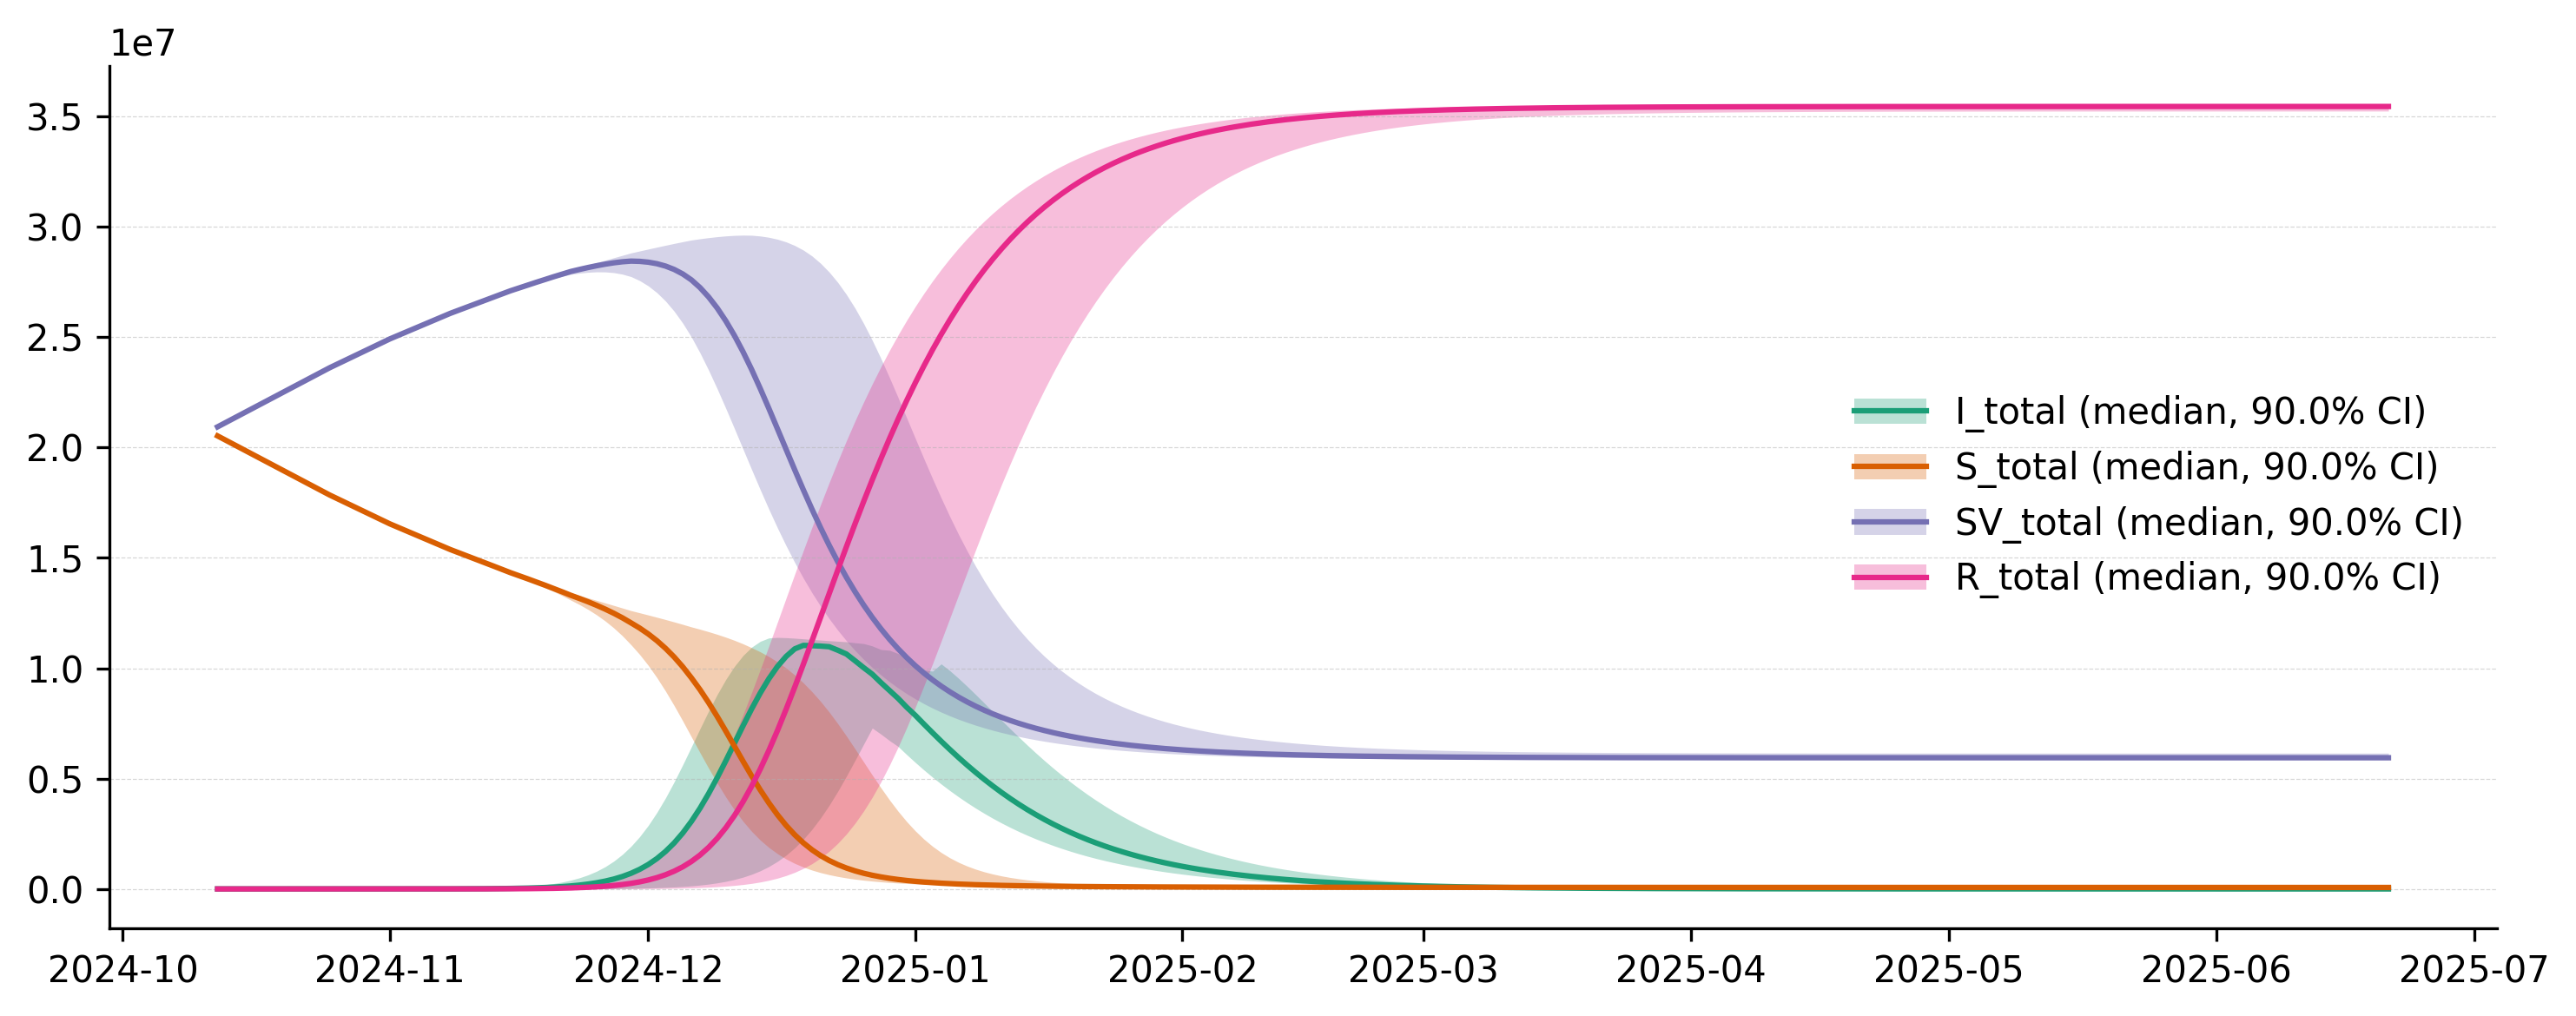

In [9]:
df_quantiles_comps = results.get_quantiles_compartments()
ax = plot_quantiles(df_quantiles_comps, columns=["I_total", "S_total", "SV_total", "R_total"], legend_loc="center right")

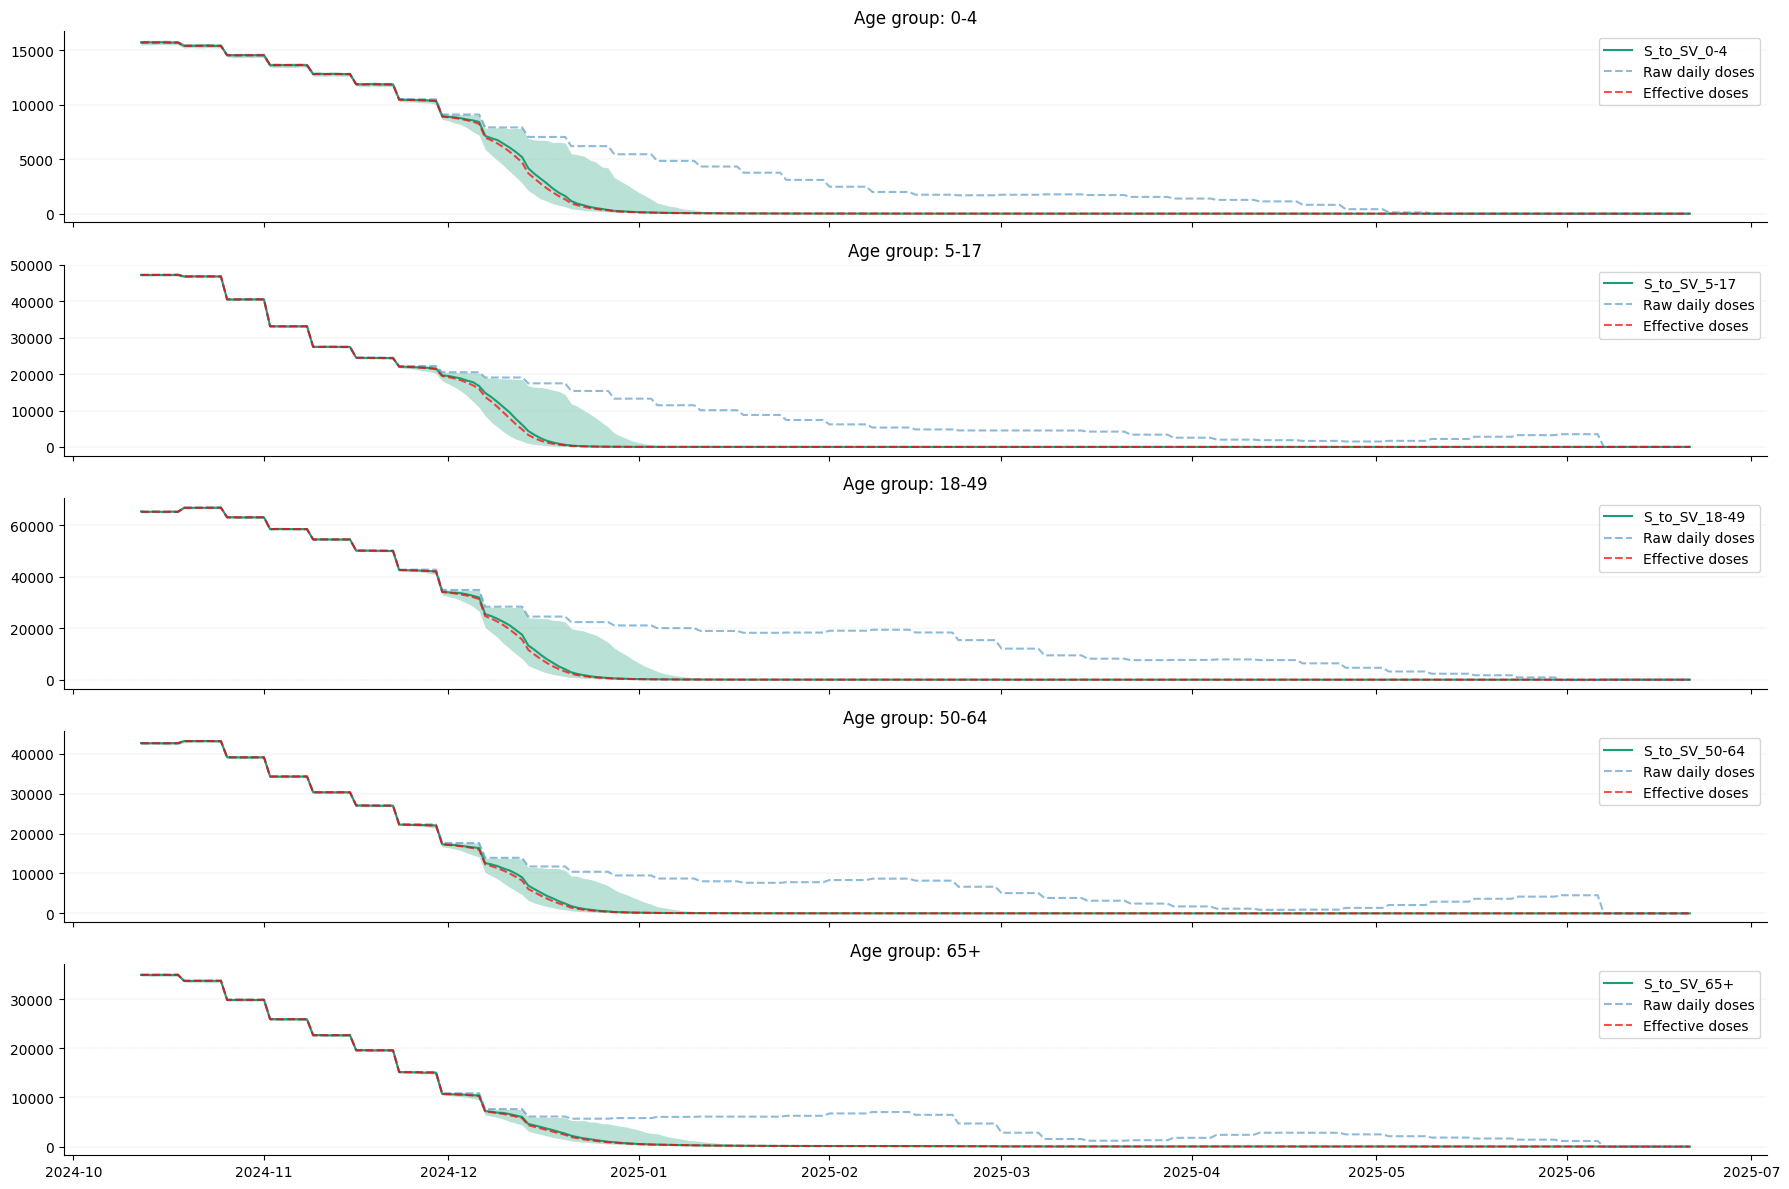

In [10]:
df_quantiles_trans = results.get_quantiles_transitions()
df_comp = results.get_quantiles_compartments()
df_median = df_comp.loc[df_comp["quantile"] == 0.5]

fig, axes = plt.subplots(5, 1, figsize=(18, 12), sharex=True)

age_groups_vax = ['0-4', '5-17', '18-49', '50-64', '65+']
age_groups_model = ['0-4', '5-17', '18-49', '50-64', '65+']

for idx, (vax_age, model_age) in enumerate(zip(age_groups_vax, age_groups_model)):
    # compute effective doses
    S = df_median[f"S_{model_age}"].values
    R = df_median[f"R_{model_age}"].values
    eligible = S + R
    fraction_S = np.where(eligible > 0, S / eligible, 0)
    effective_doses = vaccination_schedule[vax_age].values * fraction_S
    vaccination_schedule[f"effective_doses_{vax_age}"] = effective_doses

    ax = plot_quantiles(df_quantiles_trans, columns=[f"S_to_SV_{model_age}"], legend_loc="center right", ax=axes[idx])
    ax.plot(vaccination_schedule["dates"], vaccination_schedule[vax_age], linestyle="--", alpha=0.5, label="Raw daily doses")
    ax.plot(vaccination_schedule["dates"], vaccination_schedule[f"effective_doses_{vax_age}"], linestyle="--", alpha=0.7, color="r", label="Effective doses")
    ax.set_title(f"Age group: {vax_age}")
    ax.legend()

plt.tight_layout()
plt.show()
